In [4]:

!pip install -q gradio
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import json
import os

In [3]:
# Verify GPU
print("GPU Available:", tf.config.list_physical_devices('GPU'))
tf.random.set_seed(42)



GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [4]:


train_dir = '/kaggle/input/plantvillage/PlantVillage/train'  # Update with your dataset path
val_dir = '/kaggle/input/plantvillage/PlantVillage/val'      # Update with your dataset path


In [4]:
# Parameters
IMG_SIZE = 128
BATCH_SIZE = 64
EPOCHS = 50

In [5]:
# Data generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 43444 images belonging to 38 classes.
Found 10861 images belonging to 38 classes.


In [6]:

class_indices = {v: k for k, v in train_data.class_indices.items()}
with open('class_indices.json', 'w') as f:
    json.dump(class_indices, f)


In [7]:

import tensorflow as tf
from tensorflow.keras import layers, Model


class PatchExtractor(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        return tf.reshape(patches, [batch_size, -1, patch_dims])

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads
        
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        # Convert to float32 for stable attention
        query = tf.cast(query, tf.float32)
        key = tf.cast(key, tf.float32)
        value = tf.cast(value, tf.float32)
        
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        return self.combine_heads(concat_attention)

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super().__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.mlp = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation=tf.nn.gelu),
            layers.Dropout(dropout),
            layers.Dense(embed_dim),
            layers.Dropout(dropout)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs):
        # Ensure consistent dtype
        inputs = tf.cast(inputs, tf.float32)
        attn_output = self.att(inputs)
        out1 = self.layernorm1(inputs + attn_output)
        mlp_output = self.mlp(out1)
        return self.layernorm2(out1 + mlp_output)



In [8]:

# ViT Model Construction

def build_vit():
    input_shape = (128, 128, 3)
    patch_size = 16
    num_patches = (input_shape[0] // patch_size) ** 2
    projection_dim = 64
    num_heads = 8
    transformer_layers = 6
    mlp_head_units = [512, 256]
    
    inputs = layers.Input(shape=input_shape)
    # Patch extraction
    patches = PatchExtractor(patch_size)(inputs)
    # Encoding
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    # Transformer blocks
    for _ in range(transformer_layers):
        encoded_patches = TransformerBlock(projection_dim, num_heads, mlp_head_units[0])(encoded_patches)
    # Classification head
    features = layers.GlobalAveragePooling1D()(encoded_patches)
    outputs = layers.Dense(38, activation='softmax')(features)
    
    return Model(inputs=inputs, outputs=outputs)

# Build and verify
vit = build_vit()
vit.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_extractor (PatchExtractor)     │ (None, None, 768)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_encoder (PatchEncoder)         │ (None, 64, 64)              │          53,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 64, 64)              │          83,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_1                  │ (None, 64, 64)              │          83,008 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_2                  │ (None, 64, 64)              │          83,008 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_3                  │ (None, 64, 64)              │          83,008 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_4                  │ (None, 64, 64)              │          83,008 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_5                  │ (None, 64, 64)              │          83,008 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 38)                  │           2,470 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 553,830 (2.11 MB)

 Trainable params: 553,830 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:

vit.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_vit.keras', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
]


In [12]:

# Train
history = vit.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


679/679 ━━━━━━━━━━━━━━━━━━━━ 560s 773ms/step - accuracy: 0.2482 - loss: 2.8179 - val_accuracy: 0.6564 - val_loss: 1.1846 - learning_rate: 3.0000e-04
Epoch 2/50
679/679 ━━━━━━━━━━━━━━━━━━━━ 269s 393ms/step - accuracy: 0.6421 - loss: 1.1991 - val_accuracy: 0.7523 - val_loss: 0.8067 - learning_rate: 3.0000e-04
Epoch 3/50
679/679 ━━━━━━━━━━━━━━━━━━━━ 268s 389ms/step - accuracy: 0.7494 - loss: 0.8160 - val_accuracy: 0.8376 - val_loss: 0.5383 - learning_rate: 3.0000e-04
Epoch 4/50
679/679 ━━━━━━━━━━━━━━━━━━━━ 236s 345ms/step - accuracy: 0.8021 - loss: 0.6301 - val_accuracy: 0.8175 - val_loss: 0.5656 - learning_rate: 3.0000e-04
Epoch 5/50
679/679 ━━━━━━━━━━━━━━━━━━━━ 235s 343ms/step - accuracy: 0.8284 - loss: 0.5467 - val_accuracy: 0.8464 - val_loss: 0.4728 - learning_rate: 3.0000e-04
Epoch 6/50
679/679 ━━━━━━━━━━━━━━━━━━━━ 242s 354ms/step - accuracy: 0.8404 - loss: 0.4907 - val_accuracy: 0.8589 - val_loss: 0.4558 - learning_rate: 3.0000e-04
Epoch 7/50
679/679 ━━━━━━━━━━━━━━━━━━━━ 240s 350ms/

In [14]:
# 1. Evaluate on validation set
val_loss, val_accuracy = vit.evaluate(val_data)
print(f"\nFinal Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

170/170 ━━━━━━━━━━━━━━━━━━━━ 16s 92ms/step - accuracy: 0.9612 - loss: 0.1152

Final Validation Accuracy: 97.17%
Validation Loss: 0.0849


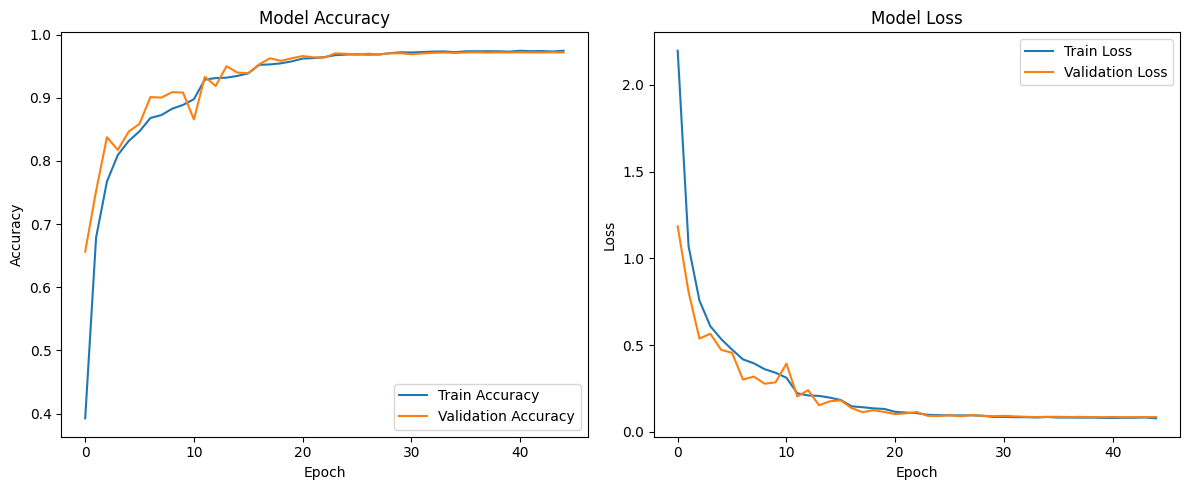

In [15]:
# 2. Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [16]:
# 3. Generate classification report
val_data.reset()  # Reset generator
y_pred = vit.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nClassification Report:")
print(classification_report(val_data.classes, y_pred_classes, target_names=class_indices.values()))

170/170 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.94      0.89      0.91       126
                                 Apple___Black_rot       0.95      0.98      0.96       125
                          Apple___Cedar_apple_rust       0.95      0.73      0.82        55
                                   Apple___healthy       0.96      0.97      0.96       329
                               Blueberry___healthy       0.98      0.98      0.98       300
          Cherry_(including_sour)___Powdery_mildew       0.94      0.97      0.96       210
                 Cherry_(including_sour)___healthy       0.99      0.99      0.99       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.82      0.92      0.87       103
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       239
           

In [17]:
# 4. Save validation results
results = {
    'val_accuracy': float(val_accuracy),
    'val_loss': float(val_loss),
    'class_report': classification_report(val_data.classes, y_pred_classes, 
                                       target_names=class_indices.values(), output_dict=True)
}

with open('validation_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("\nValidation results saved to 'validation_results.json'")


Validation results saved to 'validation_results.json'


In [19]:
vit.save('plant_disease_vit.keras')  # New recommended format
print("Model saved as 'plant_disease_vit.keras'")

Model saved as 'plant_disease_vit.keras'


To run the code again

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import keras

# Register custom layers with Keras serialization
@keras.saving.register_keras_serializable()
class PatchExtractor(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        return tf.reshape(patches, [batch_size, -1, patch_dims])

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

@keras.saving.register_keras_serializable()
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = layers.Dense(projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
    
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection.units
        })
        return config

@keras.saving.register_keras_serializable()
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads
        
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        return self.combine_heads(concat_attention)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads
        })
        return config

@keras.saving.register_keras_serializable()
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout
        
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.mlp = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation=tf.nn.gelu),
            layers.Dropout(dropout),
            layers.Dense(embed_dim),
            layers.Dropout(dropout)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs):
        attn_output = self.att(inputs)
        out1 = self.layernorm1(inputs + attn_output)
        mlp_output = self.mlp(out1)
        return self.layernorm2(out1 + mlp_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "mlp_dim": self.mlp_dim,
            "dropout": self.dropout
        })
        return config

# Now load the model with custom_objects
try:
    model = tf.keras.models.load_model(
        '/kaggle/input/vit/keras/default/1/plant_disease_vit.keras',
        custom_objects={
            'PatchExtractor': PatchExtractor,
            'PatchEncoder': PatchEncoder,
            'MultiHeadSelfAttention': MultiHeadSelfAttention,
            'TransformerBlock': TransformerBlock
        }
    )
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'patch_encoder_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_block_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'transformer_block_7', however

Model loaded successfully!


In [6]:
# %% [code]
# ======================
# Complete Gradio UI Implementation
# ======================
import gradio as gr
import numpy as np
from PIL import Image
import json
import tensorflow as tf

# Load class indices
with open('/kaggle/input/classindice/class_indices.json') as f:
    class_indices = json.load(f)
    # Convert keys to integers if needed
    class_indices = {int(k): v for k, v in class_indices.items()}

# Custom CSS for the interface
custom_css = """
:root {
    --primary: #4CAF50;
    --secondary: #8BC34A;
    --accent: #FFC107;
    --light: #F5F5F5;
    --dark: #333333;
}

.gradio-container {
    max-width: 800px !important;
    margin: 0 auto !important;
    font-family: 'Helvetica Neue', Arial, sans-serif !important;
}

.header {
    text-align: center;
    padding: 1.5rem;
    background-color: var(--primary);
    color: white;
    border-radius: 8px 8px 0 0;
    margin-bottom: 1rem;
}

.header h1 {
    margin: 0;
    font-size: 1.8rem;
    font-weight: 600;
}

.header p {
    margin: 0.5rem 0 0;
    opacity: 0.9;
}

.upload-container {
    background: white;
    padding: 1.5rem;
    border-radius: 8px;
    box-shadow: 0 2px 10px rgba(0,0,0,0.05);
    margin-bottom: 1rem;
}

.result-container {
    background: white;
    padding: 2rem;
    border-radius: 8px;
    box-shadow: 0 2px 10px rgba(0,0,0,0.05);
    margin-top: 1.5rem;
}

.predicted-class {
    background: rgba(76, 175, 80, 0.1);
    padding: 1.5rem;
    border-radius: 8px;
    border-left: 4px solid var(--primary);
    margin-bottom: 1.5rem;
}

.predicted-class h3 {
    margin-top: 0;
    color: var(--primary);
}

.confidence-results {
    margin-top: 1.5rem;
}

.confidence-item {
    margin-bottom: 1.5rem;
    padding-bottom: 1.5rem;
    border-bottom: 1px solid #eee;
}

.confidence-item:last-child {
    margin-bottom: 0;
    padding-bottom: 0;
    border-bottom: none;
}

.confidence-name {
    font-weight: 500;
    margin-bottom: 0.5rem;
    display: flex;
    justify-content: space-between;
}

.confidence-value {
    color: var(--primary);
    font-weight: 600;
}

.confidence-bar {
    height: 10px;
    background-color: #e0e0e0;
    border-radius: 5px;
    margin: 0.5rem 0;
    overflow: hidden;
}

.confidence-fill {
    height: 100%;
    background: linear-gradient(90deg, var(--secondary), var(--primary));
    border-radius: 5px;
}

.btn-primary {
    background: var(--primary) !important;
    color: white !important;
    border: none !important;
    padding: 0.75rem 1.5rem !important;
    border-radius: 4px !important;
    font-weight: 500 !important;
    transition: all 0.2s ease !important;
}

.btn-primary:hover {
    background: #3d8b40 !important;
    transform: translateY(-1px) !important;
    box-shadow: 0 2px 5px rgba(0,0,0,0.1) !important;
}

.btn-secondary {
    background: var(--light) !important;
    color: var(--dark) !important;
    border: 1px solid #ddd !important;
    padding: 0.75rem 1.5rem !important;
    border-radius: 4px !important;
    transition: all 0.2s ease !important;
}

.btn-secondary:hover {
    background: #eee !important;
}

.example-img {
    border-radius: 4px;
    cursor: pointer;
    transition: all 0.2s ease;
}

.example-img:hover {
    transform: scale(1.02);
    box-shadow: 0 2px 10px rgba(0,0,0,0.1);
}

.footer {
    text-align: center;
    margin-top: 1rem;
    color: #666;
    font-size: 0.9rem;
}
"""

def predict_disease(img):
    if img is None:
        return "Please upload an image"
    
    try:
        # Convert and preprocess image
        img = Image.fromarray(img.astype('uint8'))
        img = img.resize((128, 128))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) / 255.0
        
        # Get predictions
        predictions = model.predict(img_array, verbose=0)[0]
        top_classes = np.argsort(predictions)[-3:][::-1]
        
        # Get predicted class (highest confidence)
        predicted_class = class_indices[top_classes[0]]
        predicted_confidence = float(predictions[top_classes[0]])
        
        # Format results HTML
        results = f"""
        <div class='predicted-class'>
            <h3>Predicted Class</h3>
            <div class='confidence-name'>
                <span>{predicted_class.replace('___', ' ')}</span>
                <span class='confidence-value'>{predicted_confidence*100:.1f}% confidence</span>
            </div>
            <div class='confidence-bar'>
                <div class='confidence-fill' style='width:{predicted_confidence*100}%'></div>
            </div>
        </div>
        
        <div class='confidence-results'>
            <h3>Top 3 Predictions</h3>
        """
        
        for i in top_classes:
            confidence = float(predictions[i])
            disease_name = class_indices[i]
            results += f"""
            <div class='confidence-item'>
                <div class='confidence-name'>
                    <span>{disease_name.replace('___', ' ')}</span>
                    <span class='confidence-value'>{confidence*100:.1f}%</span>
                </div>
                <div class='confidence-bar'>
                    <div class='confidence-fill' style='width:{confidence*100}%'></div>
                </div>
            </div>
            """
        
        results += "</div>"
        return results
    
    except Exception as e:
        return f"Error processing image: {str(e)}"

# Create the interface
with gr.Blocks(css=custom_css, theme=gr.themes.Default()) as demo:
    with gr.Column():
        # Header
        with gr.Column(elem_classes=["header"]):
            gr.Markdown("""
            # 🌿 Plant Disease Classifier
            Upload an image of a plant leaf to identify potential diseases
            """)
        
        # Upload section
        with gr.Column(elem_classes=["upload-container"]):
            image_input = gr.Image(label="Leaf Image", type="numpy")
            
            with gr.Row():
                submit_btn = gr.Button("Analyze", elem_classes=["btn-primary"])
                clear_btn = gr.Button("Clear", elem_classes=["btn-secondary"])
        
        # Examples - update these paths to match your dataset
        gr.Examples(
            examples=[
                ["/kaggle/input/plantvillage/PlantVillage/train/Apple___Cedar_apple_rust/0321e067-d13b-47d0-b3a6-76ba6f357d02___FREC_C.Rust 3667.JPG"],
                ["/kaggle/input/plantvillage/PlantVillage/train/Strawberry___Leaf_scorch/0138e78b-9802-43b5-b40e-84c38160418c___RS_L.Scorch 1289.JPG"]
            ],
            inputs=image_input,
            label="Try these examples:",
            examples_per_page=2
        )
        
        # Results section
        with gr.Column(elem_classes=["result-container"]):
            result_output = gr.HTML(label="Analysis Results")
        
        # Footer
        gr.Markdown("""
        <div class="footer">
        Powered by Vision Transformer AI | PlantVillage Dataset | 38 Disease Classes
        </div>
        """)

    # Button actions
    submit_btn.click(
        fn=predict_disease,
        inputs=image_input,
        outputs=result_output
    )
    
    clear_btn.click(
        fn=lambda: [None, ""],  # Clear both image and results
        inputs=None,
        outputs=[image_input, result_output]
    )

# Launch the interface
demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://b40af9b57362ee2f19.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
